In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

In [2]:
train_path = "/kaggle/input/train-data"
test_path = "/kaggle/input/test-data"

IMG_HEIGHT = 48
IMG_WIDTH = 48

BATCH_SIZE = 64 # for model.fit()
EPOCHS = 45

LR = 0.0002
NUM_CLASSES = 5
PATIENCE = 4 # For Early stopping

CLASS_LABELS  = ['Anger', 'Happy', 'Neutral', 'Sadness', 'Surprise']
EMOJIS = ["👿", "😊" , "😐", "😔" , "😲" ]

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0.2,

                                  )

train_generator = train_datagen.flow_from_directory(
                        directory = train_path,
                        target_size = (IMG_HEIGHT ,IMG_WIDTH),
                        batch_size = BATCH_SIZE,
                        shuffle  = True , 
                        color_mode = "grayscale",
                        class_mode = "categorical",
                        subset = "training",
                        seed = 12
                       )
validation_generator = train_datagen.flow_from_directory(
                        directory = train_path,
                        target_size = (IMG_HEIGHT ,IMG_WIDTH),
                        batch_size = BATCH_SIZE,
                        shuffle  = True , 
                        color_mode = "grayscale",
                        class_mode = "categorical",
                        subset = "validation",
                        seed = 12
                    )

Found 45 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [5]:
emos = os.listdir(train_path)
counts = []
for e in emos:
    counts.append(len(os.listdir(train_path + f'/{e}')))
    
counts

[11, 11, 11, 11, 11]

In [6]:
df_hist = pd.DataFrame()
df_hist['emo'] = EMOJIS 
df_hist['count'] = counts
df_hist

,emo,count
0,👿,11
1,😊,11
2,😐,11
3,😔,11
4,😲,11


In [7]:
px.bar(df_hist, x='emo', y='count')

In [8]:
imgs , labels = validation_generator.next()
validation_generator.reset()
len(imgs)

10

(48, 48, 1)
Neutral


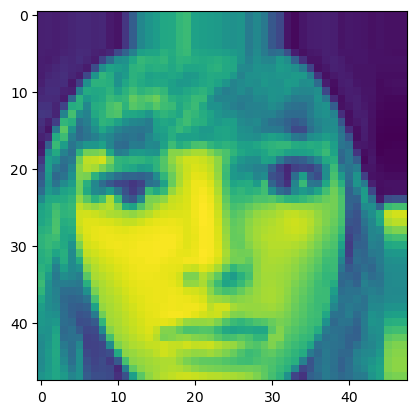

Surprise


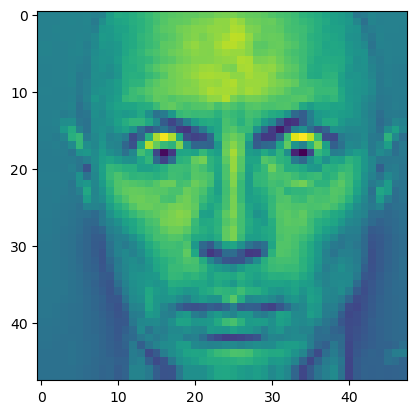

Sadness


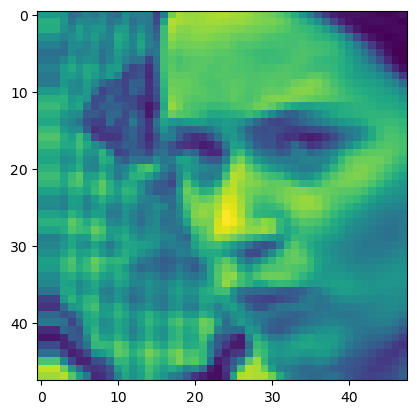

Anger


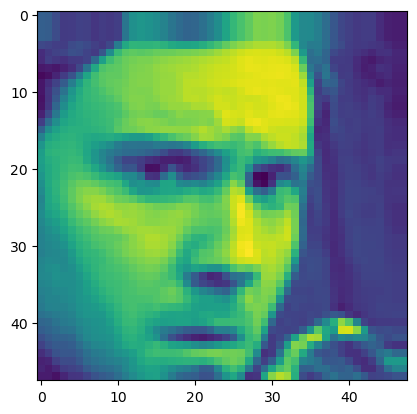

Neutral


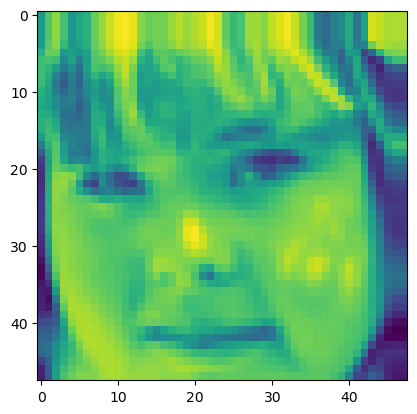

Surprise


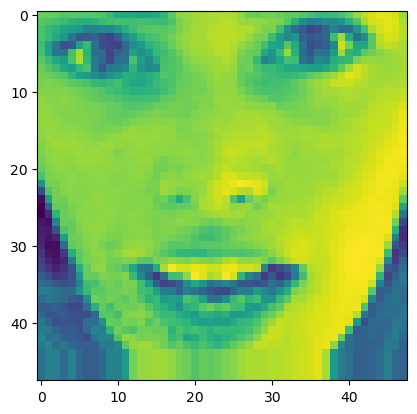

Happy


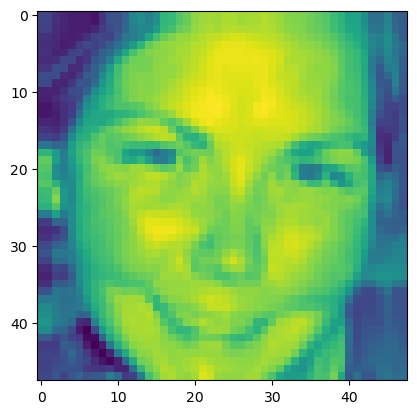

Happy


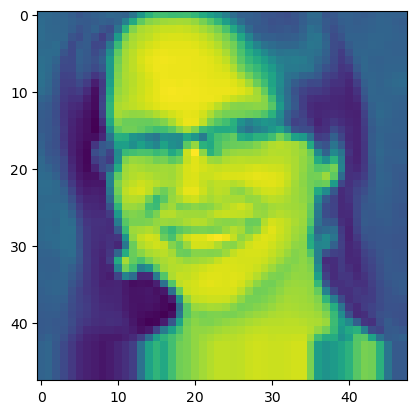

Anger


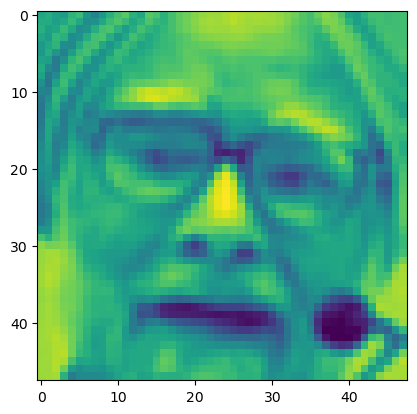

Sadness


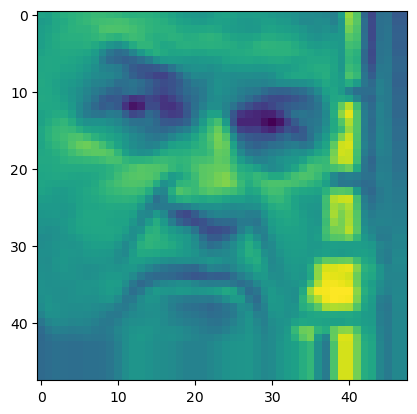

IndexError: index 10 is out of bounds for axis 0 with size 10

In [9]:
img = imgs[0]
print(img.shape)

for i in range(15):
    print(CLASS_LABELS[np.argmax(labels[i])])
    plt.imshow(imgs[i])
    plt.show()

In [10]:
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras.models import Model,Sequential
from keras import regularizers
from tensorflow.keras.optimizers import Adam,SGD,RMSprop

In [11]:
model = Sequential()

model.add(Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block1_conv1', 
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 1) ))
model.add(Conv2D(64, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block1_conv2'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='block1_maxpool'))

model.add(Conv2D(128, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block2_conv1'))
model.add(Conv2D(128, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block2_conv2'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='block2_maxpool'))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv1'))
model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv2'))
model.add(Conv2D(256, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block3_conv3'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='block3_maxpool'))

model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv1'))
model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv2'))
model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block4_conv3'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='block4_maxpool'))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv1'))
model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv2'))
model.add(Conv2D(512, (3,3), activation="relu", padding="same", kernel_initializer='he_uniform', name='block5_conv3'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='block5_maxpool'))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_maxpool (MaxPooling2  (None, 24, 24, 64)       0         
 D)                                                              
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_maxpool (MaxPooling2  (None, 12, 12, 128)      0         
 D)                                                     

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


model.compile(
    optimizer = Adam(learning_rate = LR), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

checkpoint = ModelCheckpoint("checkpoint_weights", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                          patience= PATIENCE,
                          verbose=1,
                          restore_best_weights=True
                          )
CALLBACKS = [early_stopping, checkpoint]

In [13]:
history = model.fit(x = train_generator,
                    epochs = EPOCHS ,
                    validation_data = validation_generator , 
                    callbacks = CALLBACKS 
                   )

Epoch 1/45
1/1 [==============================] - 7s 7s/step - loss: 1.6290 - accuracy: 0.2000 - val_loss: 2.4651 - val_accuracy: 0.2000
Epoch 2/45
1/1 [==============================] - 3s 3s/step - loss: 3.1074 - accuracy: 0.2000 - val_loss: 1.6717 - val_accuracy: 0.2000
Epoch 3/45
1/1 [==============================] - 3s 3s/step - loss: 1.7559 - accuracy: 0.2000 - val_loss: 1.6228 - val_accuracy: 0.1000
Epoch 4/45
1/1 [==============================] - 3s 3s/step - loss: 1.6320 - accuracy: 0.2000 - val_loss: 1.6181 - val_accuracy: 0.2000
Epoch 5/45
1/1 [==============================] - 3s 3s/step - loss: 1.6228 - accuracy: 0.1778 - val_loss: 1.6133 - val_accuracy: 0.2000
Epoch 6/45
1/1 [==============================] - 3s 3s/step - loss: 1.6221 - accuracy: 0.1556 - val_loss: 1.6111 - val_accuracy: 0.2000
Epoch 7/45
1/1 [==============================] - 3s 3s/step - loss: 1.6154 - accuracy: 0.2000 - val_loss: 1.6099 - val_accuracy: 0.2000
Epoch 8/45
1/1 [=========================

In [14]:
from tensorflow.keras.models import load_model

In [15]:
model.save('/kaggle/output/model.h5')

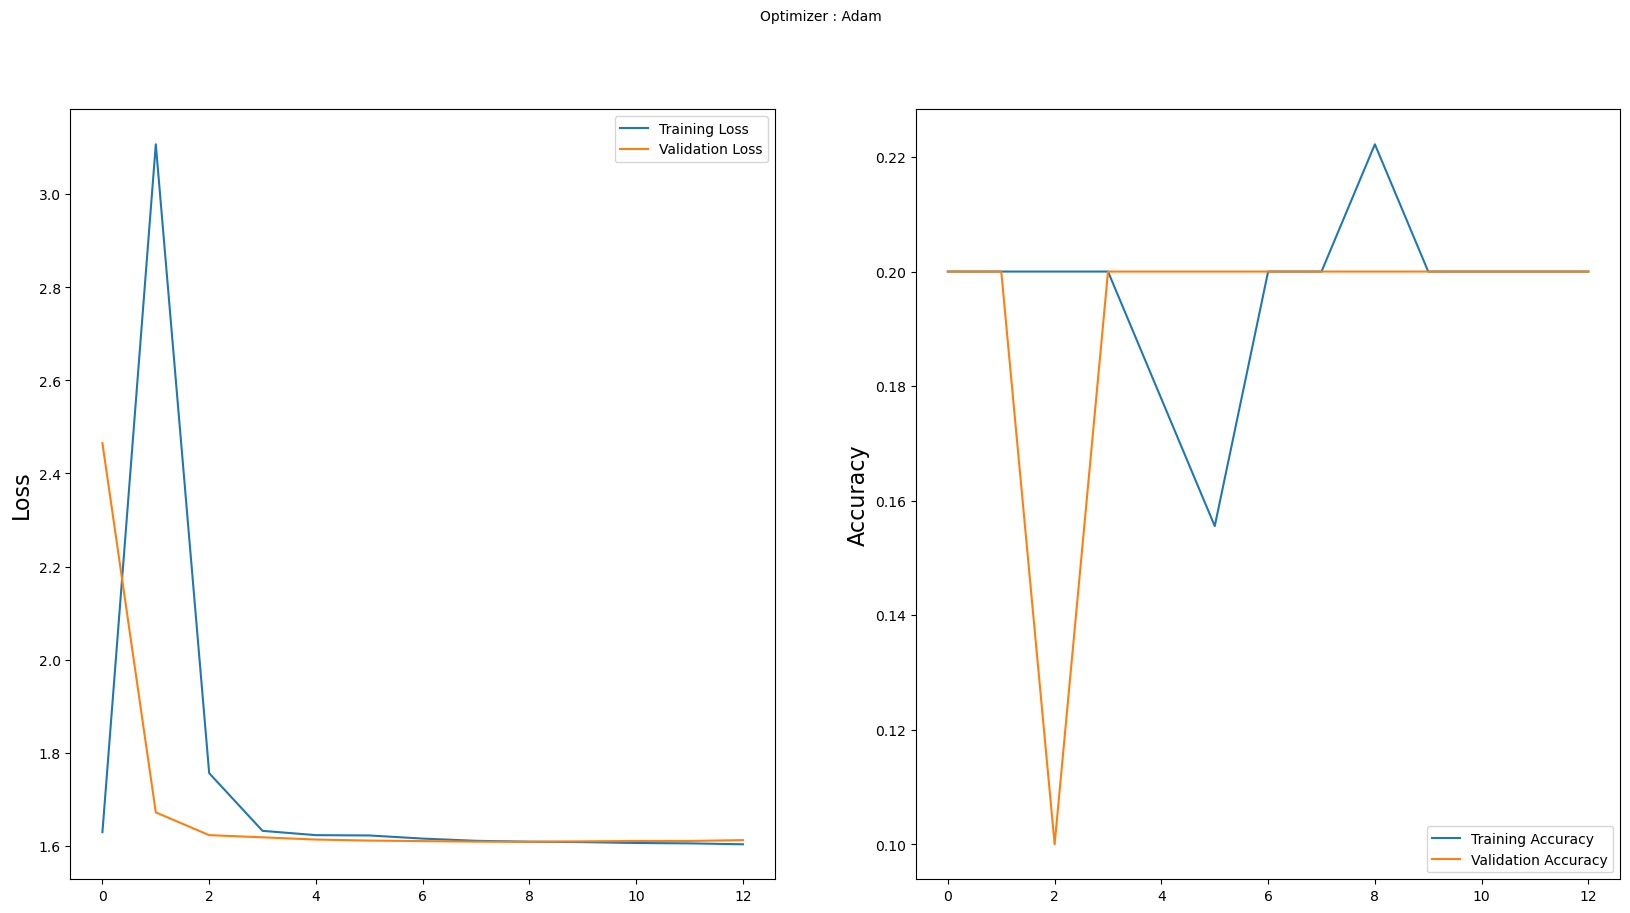

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [17]:
test_datagen = ImageDataGenerator(
                                rescale = 1./255,
                                    )

test_generator = test_datagen.flow_from_directory(
                        directory = test_path,
                        target_size = (IMG_HEIGHT ,IMG_WIDTH),
                        batch_size = BATCH_SIZE,
                        color_mode = "grayscale",
                        class_mode = "categorical",
                        shuffle = False,
                      )

Found 5 images belonging to 5 classes.


(48, 48, 1)
Neutral


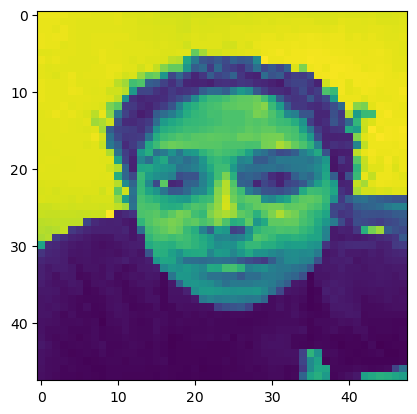

Sadness


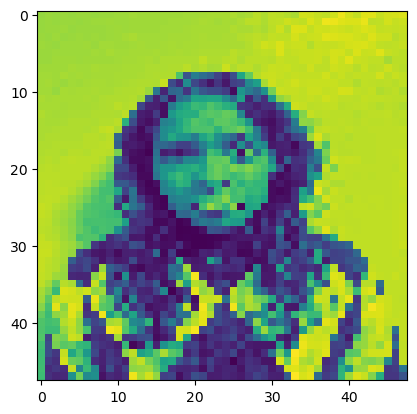

Neutral


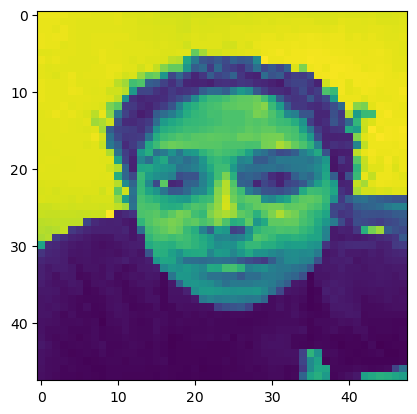

IndexError: index 5 is out of bounds for axis 0 with size 5

In [18]:
import random

imgs, labels = test_generator.next()
len(imgs)

img = imgs[0]
print(img.shape)

for i in range(4):
    index = random.randint(0, len(imgs))
    print(CLASS_LABELS[np.argmax(labels[index])])
    plt.imshow(imgs[index])
    plt.show()

In [19]:
e = model.evaluate(x=test_generator, verbose=1)

1/1 [==============================] - 0s 359ms/step - loss: 1.6099 - accuracy: 0.2000


In [20]:
test_generator.reset()
p = model.predict(test_generator)

1/1 [==============================] - 1s 524ms/step


In [21]:
test_generator.reset()
labels_test = [EMOJIS[item] for item in test_generator.labels]
labels_pred = [EMOJIS[np.argmax(item)] for item in p]

from sklearn.metrics import *
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           👿       0.00      0.00      0.00         1
           😊       0.00      0.00      0.00         1
           😐       0.00      0.00      0.00         1
           😔       0.00      0.00      0.00         1
           😲       0.20      1.00      0.33         1

    accuracy                           0.20         5
   macro avg       0.04      0.20      0.07         5
weighted avg       0.04      0.20      0.07         5



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



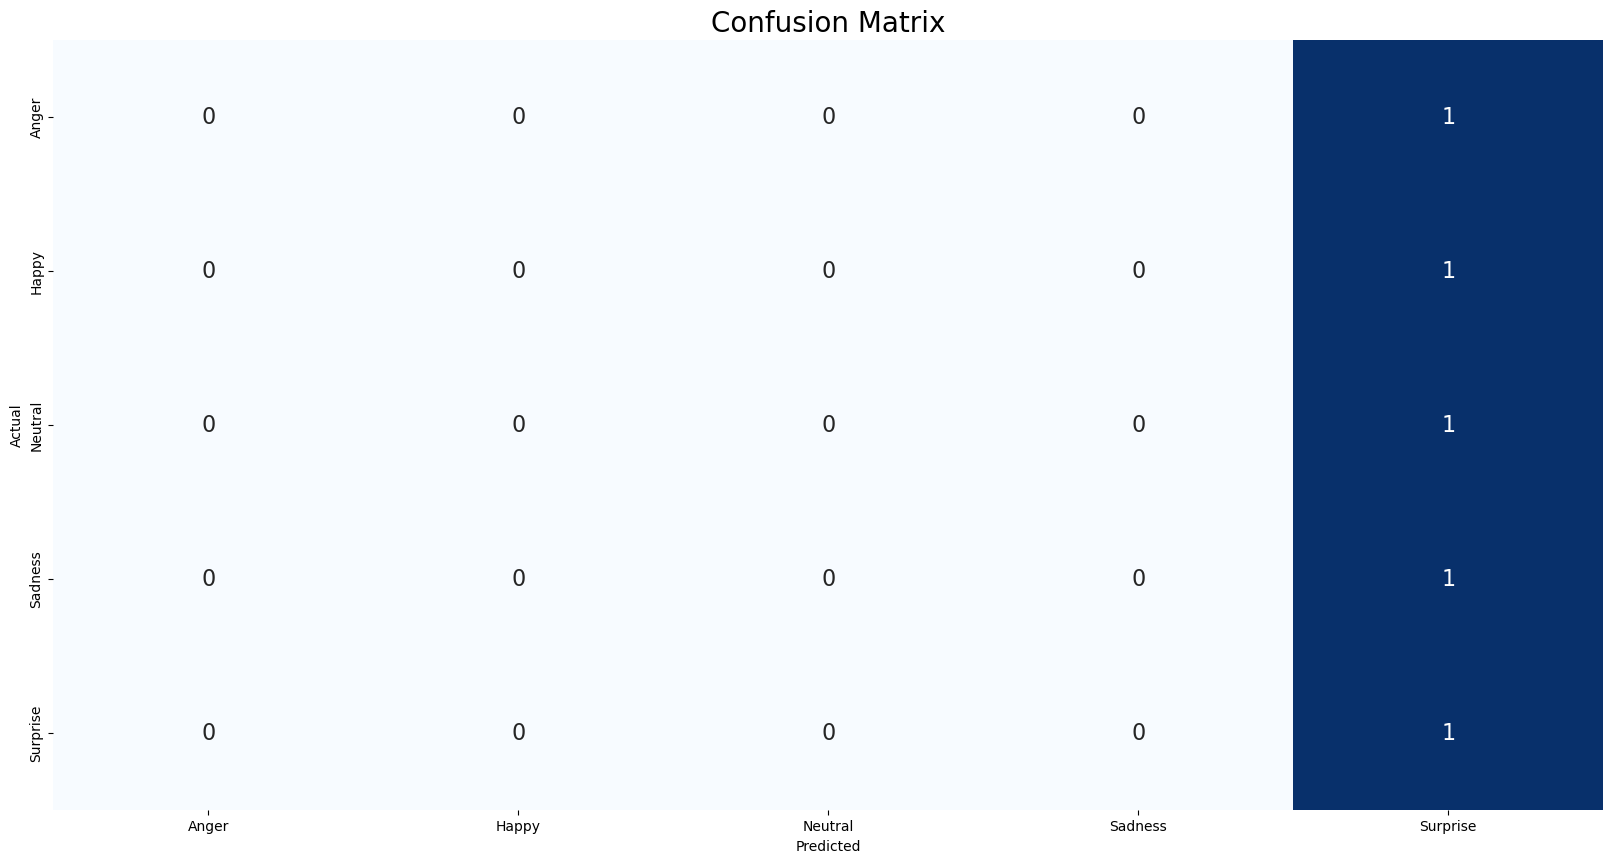

In [36]:
cm_data = confusion_matrix(labels_test, labels_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [22]:
cfm = confusion_matrix(labels_test, labels_pred)

import plotly.figure_factory as ff

# Set up figure 
fig = ff.create_annotated_heatmap(np.flipud(cfm)
, x = EMOJIS, y = list(np.flip(EMOJIS)), colorscale='Purples')

# Add titles
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  xaxis = dict(title='Predicted label'),
                  yaxis = dict(title='True label'))

# Adjust margins (top, left), width and height
fig.update_layout(margin=dict(t=100, l=100), width = 750, height = 750)

# Add colorbar
fig['data'][0]['showscale'] = True

fig.show()

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



NameError: name 'preds' is not defined

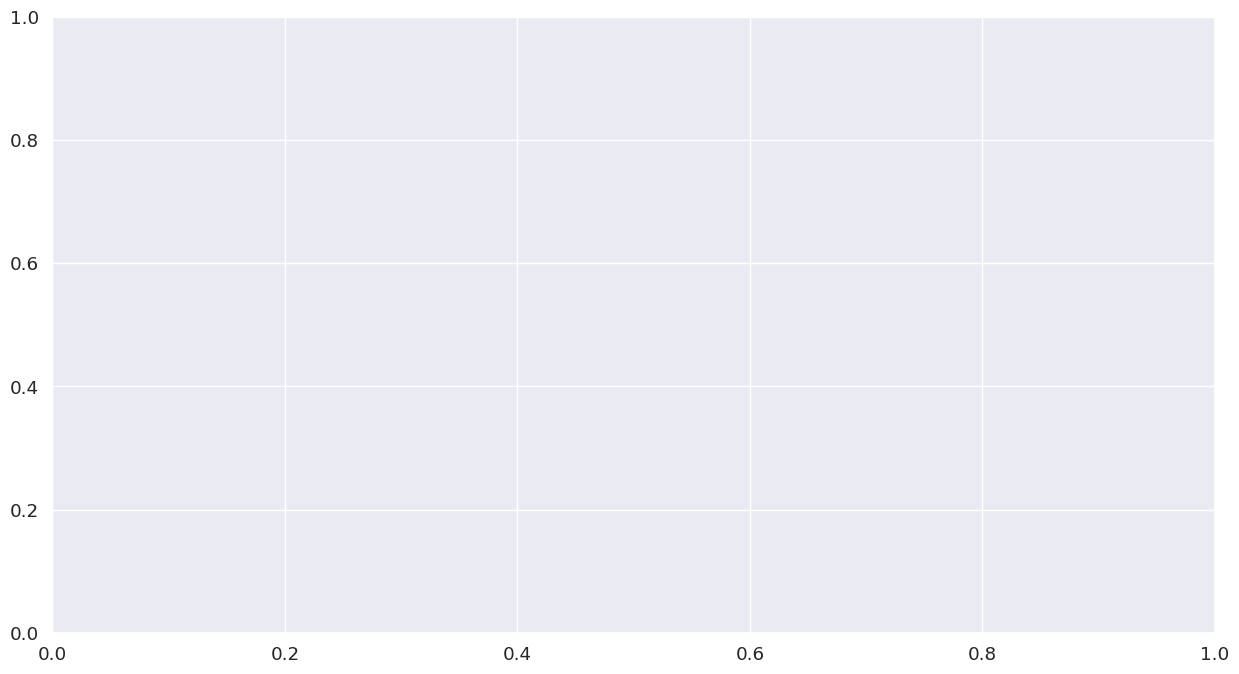

In [37]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(labels_test, labels_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(labels_test)
    labels_test = lb.transform(labels_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(labels_test[:,idx].astype(int), labels_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(labels_test, labels_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(labels_test, preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [38]:
print("ROC-AUC Score  = " ,roc_auc_score(to_categorical(y_test) , preds))

NameError: name 'y_test' is not defined

In [23]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

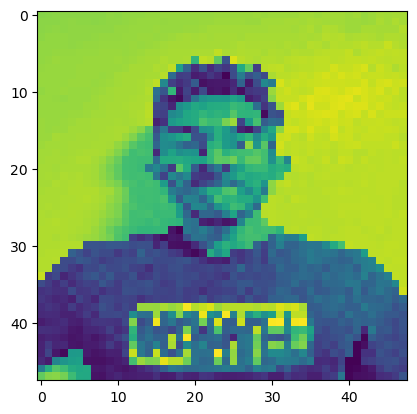

1/1 [==============================] - 0s 54ms/step
predicted: Surprise
true label: surprice


In [35]:
label = random.choice(os.listdir(test_path))
file = random.choice(os.listdir(test_path + f'/{label}'))
img_path = f'{test_path}/{label}/{file}'

# display image
img = image.load_img(img_path,target_size = (48,48),color_mode = "grayscale")
plt.imshow(img)
plt.show()

# predict
img = np.array(img)
img = np.expand_dims(img, axis=0)
img = img.reshape(1,48,48,1)

p = model.predict(img)
print('predicted:', CLASS_LABELS[np.argmax(p)])
print('true label:', label)